                                                                                                       #Nitesh Dubey

# Housing Prices Prediction For Real Estate Investment

In This Jupyter Notebook, I will try to build a model for predicting housing prices in a District based on features such as Median Income, Location, etc..

I will use the California Housing Prices Dataset for this purpose..

# Getting Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os
import tarfile
from six.moves import urllib

url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
download_path = "projectdata/housing"
if not os.path.isdir(download_path):
    os.makedirs(download_path)

tgz_path = os.path.join(download_path,"housing.tgz")
urllib.request.urlretrieve(url,tgz_path)
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall(path = download_path)
housing_tgz.close()

In [3]:
def loadhousingdata():
    csv_path = os.path.join(download_path,"housing.csv")
    return pd.read_csv(csv_path)

Now let us load the housing dataset

In [4]:
housing = loadhousingdata()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Inferences::

1.) We can see that total bedroom has only 20433, so it has some value missing...

2.) We see that median_income is not expressed in USD, so it may be the case that , median_income is already
    preprocessed
    
4.) 75% of houses have prices less than $264725.

Let us plot histograms of the features to see how they are distributed among themselves....

In [8]:
plt.style.use('ggplot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73d1236cc0>,
      dtype=object)

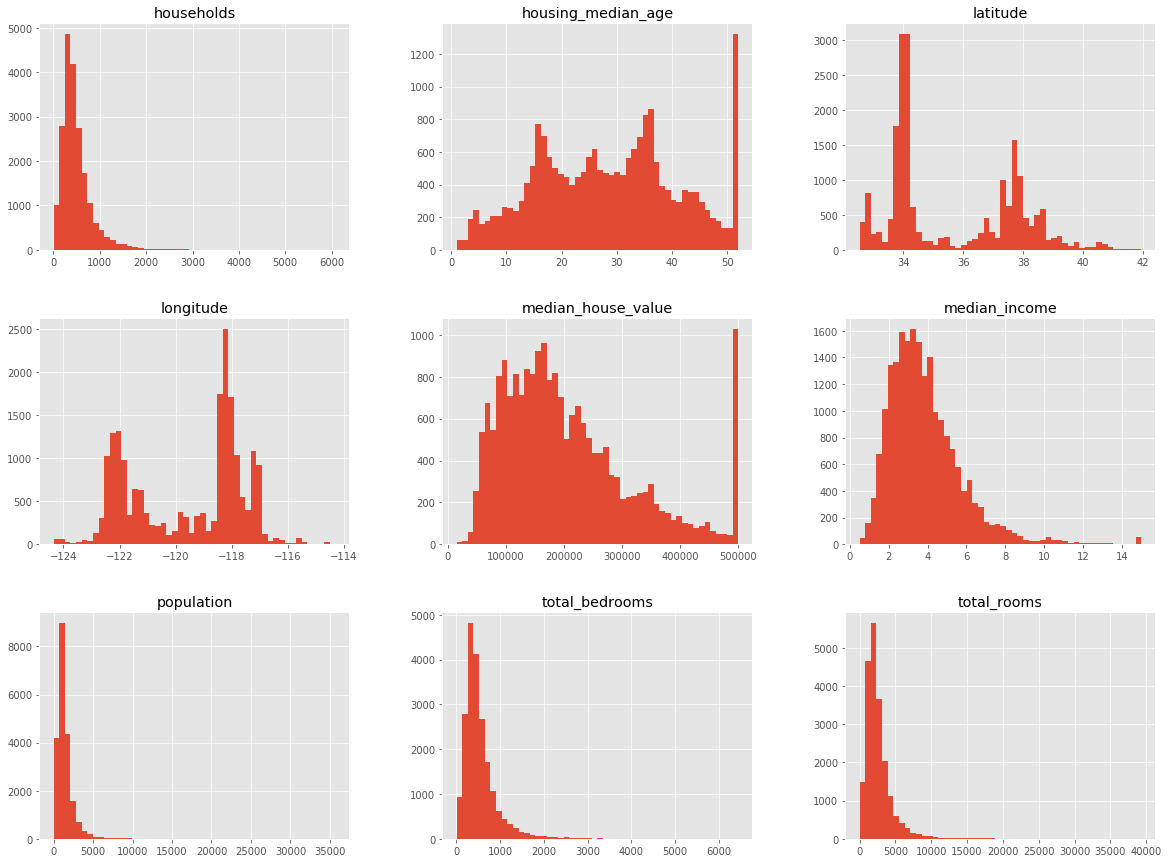

In [9]:
housing.hist(bins = 50,figsize = (20,15))

Inferences::

1.) We see that housing_median_age and median_housing_value have a long line at last, This denotes that
    all the values greater than that limit are capped to that limit...

2.) We can see that many histograms are tail heavy, i.e. they are not normally distributed.
    So to make good performance prediction model, we need to normalize the attributes.

# Creating Train and test set

We need to create Test set such that the test set is representative of Original dataset..
So Let us make median income as categorical, cap the values greater than 5 to 5 and sample right amount of instance for each category.

We are capping data to 5, because the histogram has tailing end after 5.

In [10]:
housing['median_income_cat'] = np.ceil(housing['median_income']/1.5)
housing['median_income_cat'] = housing['median_income_cat'].apply(lambda x : 5 if x > 5 else x)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index,test_index in split.split(housing,housing['median_income_cat']):
    train_strat = housing.iloc[train_index]
    test_strat = housing.iloc[test_index]


In [13]:
full_dataset_ratio = (housing.median_income_cat.value_counts()/housing.shape[0]).sort_index()
train_dataset_ratio = (train_strat.median_income_cat.value_counts()/train_strat.shape[0]).sort_index()
test_dataset_ratio = (test_strat.median_income_cat.value_counts()/test_strat.shape[0]).sort_index()

ratios = pd.concat([full_dataset_ratio,train_dataset_ratio,test_dataset_ratio], axis = 1)
ratios.columns = ['full_dataset_ratio','train_set_ratio','test_set_ratio']
ratios

,full_dataset_ratio,train_set_ratio,test_set_ratio
1.0,0.039826,0.039850,0.039729
2.0,0.318847,0.318859,0.318798
3.0,0.350581,0.350594,0.350533
4.0,0.176308,0.176296,0.176357
5.0,0.114438,0.114402,0.114583


From the above dataframe we observe that StratifiedShullleSplit has split train and test in equal ratios

Now Let us delete the attribute 'median_housing_cat'

In [14]:
for set in (train_strat,test_strat):
    set.drop(['median_income_cat'], axis = 1, inplace = True)


/home/nitesh/miniconda3/envs/av/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Data Visualization

To Visualize the data , let us create a copy of training set

In [15]:
housing = train_strat.copy()

Let us try to find pattern between longitude on train set

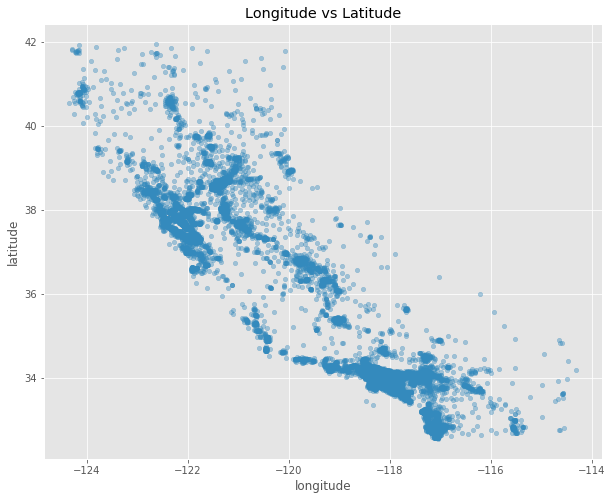

In [16]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', title = 'Longitude vs Latitude', figsize = (10,8), alpha = 0.4)

This plot resembles closely to the map of california..

Let us find relation between longitude , latitude , housing price and population

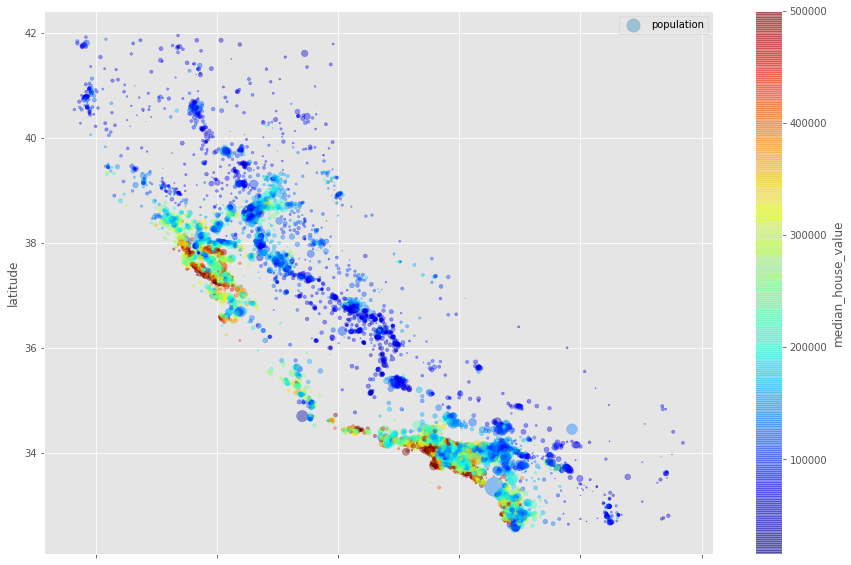

In [17]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', figsize = (15,10), alpha = 0.4,
            s = housing['population']/100, label = 'population',c = 'median_house_value', 
             cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()

1.)We observe That price of houses are high near bay area.

2.)The Price decreases as we go northwards.

3.)There are 2 clusters with high price houses..The people in these areas might be rich..

Let Us Try to find Correlations between various Features

# Finding Correlations

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

From The Above data, we see that median_income influences median_house_value very strongly..
Since the correlation coefficient is positive , so median_house_value increases with median income...

On the other hand median_house_value decreases as we go north

Let us try to experiment with more attributes..

total_rooms, total_bedrooms, population, households do not give any significant information for prediction due to less correlation constant, so but total_rooms_per_household and total_bedrooms_per_household and population_per_household seem to be interesting features. Let us try these out

In [20]:
housing_exp = housing.copy()

In [21]:
housing_exp['rooms_per_household'] = housing_exp['total_rooms']/housing_exp['households']
housing_exp['population_per_household'] = housing_exp['population']/housing_exp['households']
housing_exp['bedrooms_per_room'] = housing_exp['total_bedrooms']/housing_exp['total_rooms']

In [22]:
corr_matrix = housing_exp.corr()

In [23]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We observe that bedrooms_per_room, median_income, rooms_per_household are more correlated to median_house_value

Now let us try to plot correlation between different features

In [24]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73b674b320>,
      dtype=object)

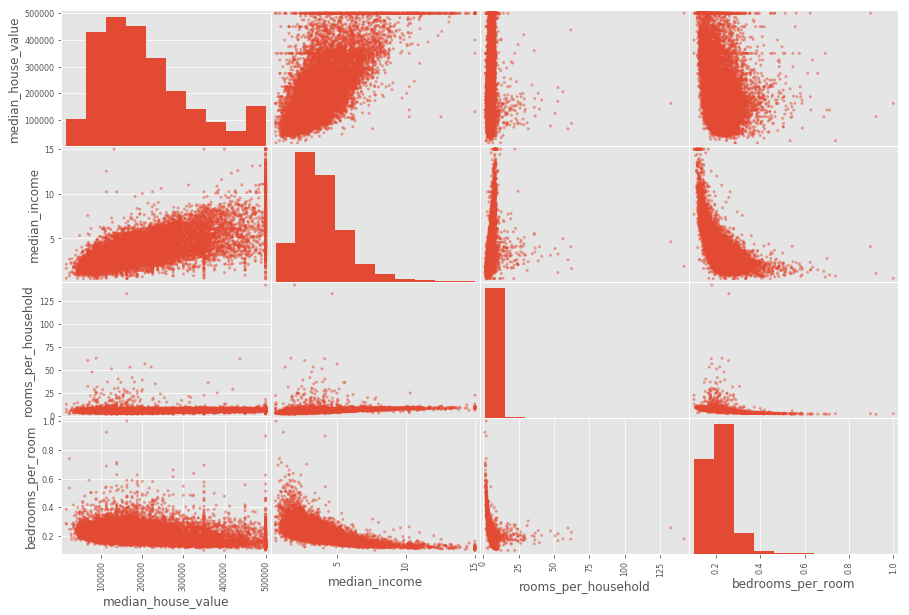

In [25]:
attr = ['median_house_value','median_income','rooms_per_household','bedrooms_per_room']
scatter_matrix(housing_exp[attr], figsize = (15,10))

From The Above figure we notice that strongest determinant of median_house_value is median_income as its has greatest correlation coefficient..

We also see notice that, as the median income of people increases, the bedrooms_per_room decreases perhaps because people become more rich

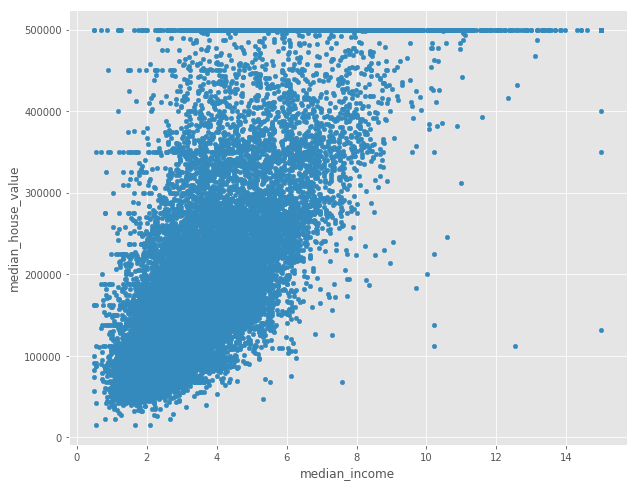

In [26]:
housing_exp.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', figsize = (10,8))

We see that although there are data quirks, but median_income is strongly related to median_house_value

We can also notice the topmost horizontal line due to capping

Now that we have gained some information about the correlations between features in dataset, which will be important for prediction, so let us now Prepare data for machine learning algorithm

# Data Preparation Pipeline

In [27]:
housing_labels = housing['median_house_value'].copy()
housing = housing.drop('median_house_value', axis = 1)

In [28]:
from sklearn.base import BaseEstimator,TransformerMixin

In [29]:
from sklearn.preprocessing import LabelBinarizer

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [31]:
housing_num = housing.copy()
housing_cat = housing['ocean_proximity'].copy()
housing_num.drop('ocean_proximity',axis = 1, inplace = True)

In [32]:
room_ind,bedroom_ind,population_ind,household_ind = 3,4,5,6
class AddAttributes(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        rooms_per_household = X[:,room_ind]/X[:,household_ind]
        population_per_household = X[:,population_ind]/X[:,household_ind]
        bedrooms_per_room = X[:,bedroom_ind]/X[:,room_ind]
        return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]

In [33]:
class DataframeSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attr):
        self.attr = attr
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        return X[self.attr].values

In [34]:
class CustomLabelBinarizer(BaseEstimator,TransformerMixin):
    def __init__(self,sparse_output = False):
        self.sparse_output = sparse_output
    def fit(self,X,y = None):
        self.enc = LabelBinarizer(sparse_output = self.sparse_output)
        self.enc.fit(X)
        return self
    def transform(self,X,y = None):
        return self.enc.transform(X)
        

In [35]:
num_pipeline = Pipeline([
    ('selector',DataframeSelector(housing_num.columns.tolist())),
    ('imputer',SimpleImputer(strategy = 'mean')),
    ('add_attr',AddAttributes()),
    ('normalize', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataframeSelector(['ocean_proximity'])),
    ('binarize',CustomLabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)


# Training and Selecting The Model

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [38]:
def Performance(scores):
    print('Mean Squared Error :',scores)
    print('Mean :',np.mean(scores))
    print('Standard Deviation :',np.std(scores))

# Performance on Training and Crossvalidation sets

# 1.) Linear Regression Model

In [39]:
lin_reg = LinearRegression()

a.) On Training set

In [40]:
lin_reg.fit(housing_prepared,housing_labels.values)
prediction = lin_reg.predict(housing_prepared)
mse_val = mse(prediction,housing_labels.values)
rmse_val = np.sqrt(mse_val)
rmse_val

68727.62070058881

b.) On cross_validation sets

In [41]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels.values,scoring = 'neg_mean_squared_error', cv = 10)
lin_rmse = np.sqrt(-lin_scores)
Performance(lin_rmse)

Mean Squared Error : [66991.93077833 67048.67926539 70444.05577272 74774.02214626
 68102.64264448 71319.00743013 65085.0968163  68353.36278098
 71773.08099554 67789.05273148]
Mean : 69168.09313616122
Standard Deviation : 2721.508666429823


Since LinearRegression isn't even performing well on Training set so it is underfitting, as the model is too simple

So let us try comples models

# 2.) DecisionTreeRegressor Model

In [42]:
dec_tree = DecisionTreeRegressor()

a.) On training set

In [43]:
dec_tree.fit(housing_prepared,housing_labels.values)
prediction = dec_tree.predict(housing_prepared)
rmse_val = np.sqrt(mse(prediction,housing_labels.values))
rmse_val

0.0

b.) On cross_validation sets

In [44]:
dec_scores = cross_val_score(dec_tree,housing_prepared,housing_labels.values,scoring = 'neg_mean_squared_error', cv = 10)
dec_rmse = np.sqrt(-dec_scores)
Performance(dec_rmse)

Mean Squared Error : [68133.65131447 66154.3017671  69959.05646693 68502.92132253
 71054.03001425 73779.79728889 71237.73862243 71303.54760935
 77021.3247614  68482.71623157]
Mean : 70562.90853989258
Standard Deviation : 2959.343584874622


An Error of 0.0 on Training set and 70493 shows that model is overfitting very badly

# 3.) RandomForestRegressor Model

In [45]:
ran_for = RandomForestRegressor(n_estimators = 10)

a.) On training set

In [46]:
ran_for.fit(housing_prepared,housing_labels.values)
prediction = ran_for.predict(housing_prepared)
rmse_val = np.sqrt(mse(prediction,housing_labels.values))
rmse_val

22209.372533915095

b.) On Cross_validation sets

In [47]:
ran_scores = cross_val_score(ran_for,housing_prepared,housing_labels.values,scoring = 'neg_mean_squared_error', cv = 10)
ran_rmse = np.sqrt(-ran_scores)
Performance(ran_rmse)

Mean Squared Error : [52143.91370292 50643.79893715 53430.74028286 54266.66097669
 52889.52915454 55738.60355071 51207.32334607 50617.59562752
 55667.79756676 51862.61666629]
Mean : 52846.85798115147
Standard Deviation : 1806.9999374273839


From the Above errors on training set and test sets...we observe that RandomForestRegressor Model Performs the Best as it has least error on both training and cross_val sets

LinearRegression Underfits whereas DecisionTree Overfits

# Fine Tuning The model with Grid Search

Since RandomForestRegressor performs the best, so let us try to find out the combination of its hyperparameters 
which will give best performance, using GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = [
    {'bootstrap' : [True],'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8,9]},
    {'bootstrap' : [False],'n_estimators': [3,10], 'max_features' : [2,3,4]}
]

ran_for = RandomForestRegressor()
grid_search = GridSearchCV(ran_for, param_grid, scoring = 'neg_mean_squared_error', cv = 5)
grid_search.fit(housing_prepared,housing_labels.values)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'bootstrap': [True], 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 9]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 6, 'n_estimators': 30}

In [51]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [52]:
result = grid_search.cv_results_
res = sorted(zip(result['mean_test_score'],result['params']), reverse = True)
for mean_score,params in res:
    print(np.sqrt(-mean_score),params)

49885.438611353304 {'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
50049.701804716235 {'bootstrap': True, 'max_features': 8, 'n_estimators': 30}
50101.78015484992 {'bootstrap': True, 'max_features': 9, 'n_estimators': 30}
50301.680121650614 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
51652.94987365735 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
52081.479215057356 {'bootstrap': True, 'max_features': 9, 'n_estimators': 10}
52355.88719955914 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
52437.6998985403 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
52650.13684122768 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
52991.535092079874 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
53206.56667351001 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
54618.43850453189 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
55294.96063965399 {'bootstrap': True, 'max_features': 2, 'n_estimator

Therefore We observe that the best estimator has root_mean_squared_error = 49876.42, with n_estimators = 30 and max_featuers = 6

# Running Model on Test Case

In [53]:
test_labels = test_strat['median_house_value'].copy()

In [54]:
test_set = test_strat.drop('median_house_value',axis = 1)

In [55]:
test_prepared = full_pipeline.transform(test_set)

In [56]:
model = grid_search.best_estimator_

In [57]:
predictions = model.predict(test_prepared)

In [58]:
rmse_val = np.sqrt(mse(predictions,test_labels.values))
rmse_val

47880.55961184709

From the mean Squared Error on Test Set we can see that RandomForestRegressor's performance on test set is good and is even better than the performance LinearRegression on Training Set and Decision Tree on Test crossval set..